##### LINE BOT 串接 Dialogflow ( 接收表情貼圖 )
因為 Dialogflow 只能處理「文字」，如果遇到「表情貼圖」、「地圖資訊」等非文字訊息，就會發生無法處理的狀況，\
這篇教學將會介紹如何透過自建的 Webhook 伺服器解析 LINE 訊息後，再將文字交由 Dialogflow 處理，\
讓串接 Dialogflow 的 LINE BOT 可以正確處理聊天訊息。

##### 本篇文章所需知識 
要實作本篇文章的範例，需要先參考下列文章，先建立自己的 LINE BOT 以及開啟 Dialogflow 專案，並於 Dialogflow 專案裡預先建立好相關的 Intent。
* [建立 LINE Channel](https://steam.oxxostudio.tw/category/python/example/line-developer.html)
* [使用 Dialogflow 打造聊天機器人](https://steam.oxxostudio.tw/category/python/example/dialogflow.html)

在之前「LINE BOT 串接 Dialogflow」的相關文章裡，都是使用 Dialogflow 產生的 Webhook 串接 LINE 機器人，\
由於這次要改成使用自建的伺服器串接 Dialogflow，所以需要額外啟用 Google Cloud 的安全性設定，請參考下方文章，\
進行相關設定：
* [伺服器串接 Dialogflow](https://steam.oxxostudio.tw/category/python/example/dialogflow-api.html)

如果已經有帳號或專案，直接點擊下方連結開始。
* [Google Dialogflow](https://dialogflow.cloud.google.com/)
* [LINE Developers](https://developers.line.biz/zh-hant/)
* [LINE 官方帳號管理頁面](https://tw.linebiz.com/login/)

伺服器串接 Dialogflow 流程圖 
架設自己的 Python 伺服器後，會透過 Webhook 網址與 LINE BOT 連結，透過 Dialogflow 的 API 和 Dialogflow 連接，可以參考下方的串接流程圖，了解相關的流程：

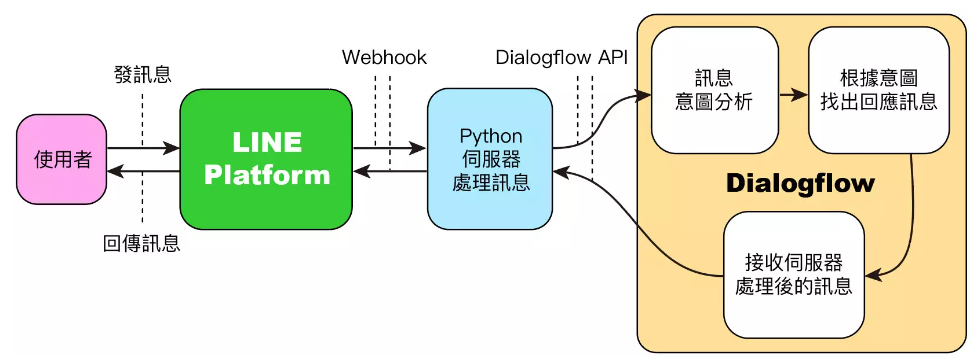

##### 接收表情貼圖 ( 本機環境 ) 
參考「伺服器串接 Dialogflow」和「建立並串接 Webhook」兩篇文章範例，將 LINE BOT 的 Webhook 程式結合 Dialogflow API，在收到 LINE 訊息時，\
解析訊息的類型 type，如果 type 為 text 表示純文字，就將訊息內容提供給 Dialogflow 進行自然語言處理，如果不是純文字，\
則直接回傳「你傳的不是文字呦」的訊息 ( 要填入自己 LINE BOT 的 Access Token 以及 Channel Secret )。

注意，因 Google Dialogflow 函式庫無法運行在 Python 3.7 的環境，所以如果遇到無法安裝的情形，請先將 Python 升級為 3.9 以上版本，\
同理，因為 Colab 預設 Python 3.7，也就無法正確安裝和執行 Google Dialogflow 函式庫。

In [ ]:
import os
import google.cloud.dialogflow_v2 as dialogflow
from flask import Flask, request

# 載入 json 標準函式庫，處理回傳的資料格式
import json

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'dialogflow_key.json' # 金鑰 json
project_id = 'XXXX'         # dialogflow project id
language = 'zh-TW'          # 語系
session_id = 'oxxostudio'   # 自訂 session id

# dialogflow 處理自然語言
def dialogflowFn(text):
    session_client = dialogflow.SessionsClient()
    session = session_client.session_path(project_id, session_id)
    text_input = dialogflow.types.TextInput(text=text, language_code=language)
    query_input = dialogflow.types.QueryInput(text=text_input)
    print(query_input)
    try:
        response = session_client.detect_intent(session=session, query_input=query_input)
        print("input:", response.query_result.query_text)
        print("intent:", response.query_result.intent.display_name)
        print("reply:", response.query_result.fulfillment_text)
        return response.query_result.fulfillment_text
    except:
        return 'error'

app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = 'Access Token'
        secret = 'Channel Secret'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        type = json_data['events'][0]['message']['type']     # 取得 LINe 收到的訊息類型
        if type=='text':
            msg = json_data['events'][0]['message']['text']  # 取得 LINE 收到的文字訊息
            print(msg)                                       # 印出內容
            reply = dialogflowFn(msg)                        # dialogflow 處理後回傳文字
        else:
            reply = '你傳的不是文字呦～'
        print(reply)
        line_bot_api.reply_message(tk,TextSendMessage(reply))# 回傳訊息
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'                                              # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

完成後使用 ngrok ( 參考「本機環境使用 ngrok」 ) 產生 Webhook，將網址填入 LINE Developer 裡，完成後與 LINE 機器人聊天，\
機器人就可以識別表情貼圖或文字，如果是文字，就會透過 Dialogflow 處理並回傳結果。

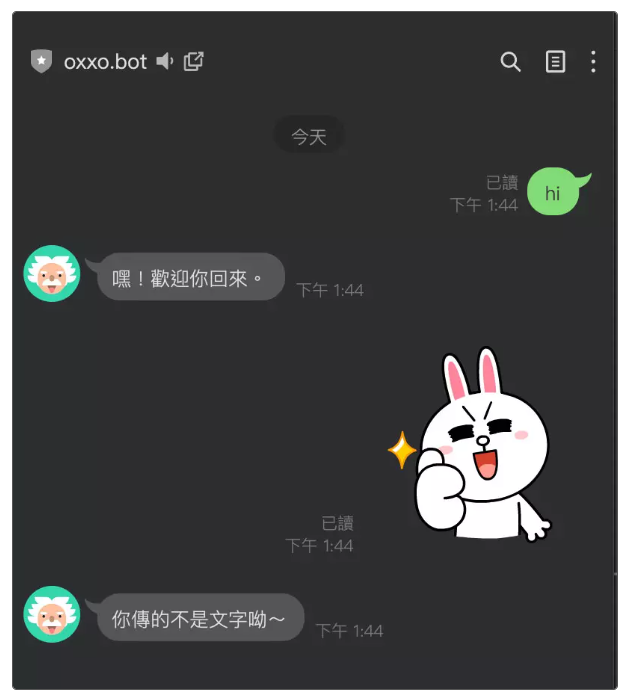

##### 接收表情貼圖 ( Cloud Functions ) 
參考「[串接 Dialogflow ( Cloud Functions )](https://steam.oxxostudio.tw/category/python/example/dialogflow-api.html#a4)」文章，進入 Cloud Functions 專案後，加入 dialogflow 的 API 金鑰 json，\
並在 requirements.txt 裡新增下列三個第三方函式庫。

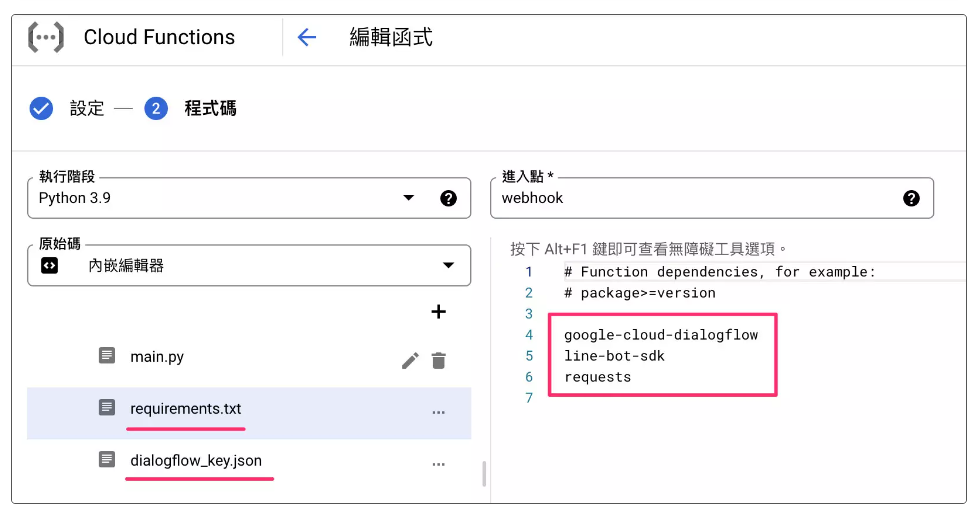

google-cloud-dialogflow

line-bot-sdk

requests

最後輸入下方的程式碼，完成後點擊下方的「部署」，就會將程式部署到 Cloud Functions 裡 ( 要填入自己 LINE BOT 的 Access Token 以及 Channel Secret )。

In [ ]:
import os
import google.cloud.dialogflow_v2 as dialogflow

import json
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'dialogflow_key.json'  # 剛剛下載的金鑰 json
project_id = 'XXXXX'        # dialogflow 的 project id
language = 'zh-TW'          # 語系
session_id = 'oxxostudio'   # 自訂義的 session id

def dialogflowFn(text):
    session_client = dialogflow.SessionsClient()                   # 使用 Token 和 dialogflow 建立連線
    session = session_client.session_path(project_id, session_id)  # 連接對應專案
    text_input = dialogflow.types.TextInput(text=text, language_code=language)  # 設定語系
    query_input = dialogflow.types.QueryInput(text=text_input)     # 根據語系取得輸入內容
    try:
        response = session_client.detect_intent(session=session, query_input=query_input) # 連線 Dialogflow 取得回應資料
        print("input:", response.query_result.query_text)
        print("intent:", response.query_result.intent.display_name)
        print("reply:", response.query_result.fulfillment_text)
        return response.query_result.fulfillment_text    # 回傳回應的文字
    except:
        return 'error'

def webhook(request):
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = 'Access Token'
        secret = 'Channel Secret'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        type = json_data['events'][0]['message']['type']     # 取得 LINe 收到的訊息類型
        if type=='text':
            msg = json_data['events'][0]['message']['text']      # 取得 LINE 收到的文字訊息
            print(msg)                                       # 印出內容
            reply = dialogflowFn(msg)
        else:
            reply = '你傳的不是文字呦～'
        print(reply)
        line_bot_api.reply_message(tk,TextSendMessage(reply))  # 回傳訊息
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'                                              # 驗證 Webhook 使用，不能省略

完成後如果成功部署，會出現綠色打勾圖示，複製觸發條件的 Webhook 網址。

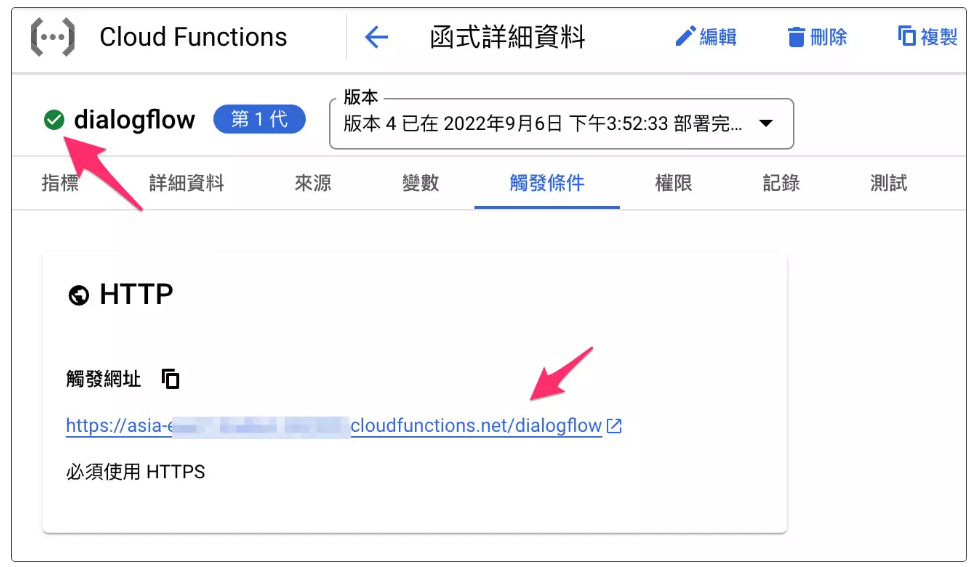

將 Webhook 網址填入 LINE Developer 裡，完成後與 LINE 機器人聊天，機器人就可以識別表情貼圖或文字，如果是文字，就會透過 Dialogflow 處理並回傳結果。

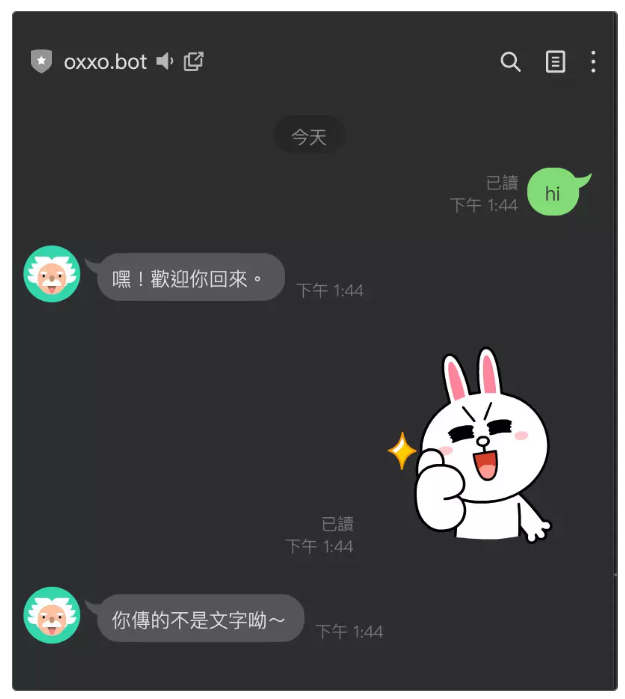